In [ ]:
## import packages
from statistics import median
import copy as cp
import numpy.matlib as npm
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from IPython import display
import time

%matplotlib inline

Set up model parameters

In [ ]:
# ##Sets of Initial values 1 and 2
# #Wave 1 
# totalpopulation = 500  #10000 per square km population density for New Delhi        
#                         #500 people in 200m*200m environment 

# s_init =  495 #initial susceptible population
# ms = 0.1 #magnitude of movement of susceptibe population ~ 20 m 
# # 0 for complete lockdown 

# i_init =  5 #initial infected population
# mi = 0.1 #magnitude of movement of infected population ~ 20 m
# #0 for complete lockdown & quarantined 

# r_init = 0 #initial recovered population

# d_init = 0 #initial dead population

# rs = 0.01 #0.0025 #recovered to susceptible rate #1 out of 100 people go back to being susceptible

# #ifr = 0.0013 #infection fatality rate #adopted from research
# ifr = 0.0046 #estimated infection fatality rate from research

# #cd = 0.02 #0.01 #contagion distance  #0.02 units is around 4 m st 3.6 m ~ 12 ft
# cd = 0.01 #0.01 units is around 2 m ~ 6 ft (less than 6 ft social distancing) 
# #contagion distance for scenario of masking and social distancing 

# cdsq = cd**2 #contagion distance squared 

# #cp = 0.9 #contagion probability - infection rate 
# cp = 0.5 #contagion probability for masking and social distancing

# recovering_time = 20 # 10 days it takes for an infected agent to recover 
# #2 update steps can be taken as half a day #coming across 2 different sets of people
# #assuming any person moves once to work and once back home

# incubation_time = 6 #3 days it takes for an infected agent to show symptoms to get quarantined

In [ ]:
#Set of initial values 3
#wave 2 

totalpopulation = 500  #10000 per square km population density for New Delhi        
                        #500 people in 200m*200m environment 

s_init =  490 #initial susceptible population
ms = 0.05 #magnitude of movement of susceptibe population ~ 10 m 
# 0 for complete lockdown 

i_init =  10 #initial infected population
mi = 0.05 #magnitude of movement of infected population ~ 10 m
#0 for complete lockdown & quarantined 

r_init = 0 #initial recovered population

d_init = 0 #initial dead population

rs = 0.005 #0.0025 #recovered to susceptible rate #1 out of 200 people go back to being susceptible

ifr = 0.0018 #infection fatality rate #adopted from research
#ifr = 0.0046 #estimated infection fatality rate from research

#cd = 0.02 #0.01 #contagion distance  #0.02 units is around 4 m st 3.6 m ~ 12 ft
cd = 0.01 #0.01 units is around 2 m ~ 6 ft (less than 6 ft social distancing) 
#contagion distance for scenario of masking and social distancing 

cdsq = cd**2 #contagion distance squared 

#cp = 0.6 #let us say it was spreading slower because some people were vaccinated
#cp = 0.9 #contagion probability - infection rate 
cp = 0.3 #contagion probability for masking and social distancing

recovering_time = 20 # 10 days it takes for an infected agent to recover 
#2 update steps can be taken as half a day #coming across 2 different sets of people
#assuming any person moves once to work and once back home

incubation_time = 6 #3 days it takes for an infected agent to show symptoms to get quarantined

Model functions

In [ ]:
class agent:
    pass

def initialize():
    global agents, sdata, idata, rdata, ddata
    agents = []
    sdata = [] #to track susceptible population
    idata = [] #to track infected population
    rdata = [] #to track recovered population
    ddata = [] #to track dead population
    for i in range(s_init + i_init):
        ag = agent()
        ag.type = 's' if i < s_init else 'i'
        ag.infected_time = 0
        ag.isquarantined = 0
        ag.x = random.random()
        ag.y = random.random()
        agents.append(ag)

def observe():
    global agents, sdata, idata, rdata, ddata

    # plt.subplot(2, 1, 1)
    # plt.cla()
    # susceptible = [ag for ag in agents if ag.type == 's']
    # if len(susceptible) > 0:
    #     x = [ag.x for ag in susceptible]
    #     y = [ag.y for ag in susceptible]
    #     plt.plot(x, y, 'b.')
    # infected = [ag for ag in agents if ag.type == 'i']
    # if len(infected) > 0:
    #     x = [ag.x for ag in infected]
    #     y = [ag.y for ag in infected]
    #     plt.plot(x, y, 'r.')
    # recovered = [ag for ag in agents if ag.type == 'r']
    # if len(recovered) > 0:
    #     x = [ag.x for ag in recovered]
    #     y = [ag.y for ag in recovered]
    #     plt.plot(x, y, 'g.')
    # dead = [ag for ag in agents if ag.type == 'd']
    # if len(dead) > 0:
    #     x = [ag.x for ag in dead]
    #     y = [ag.y for ag in dead]
    #     plt.plot(x, y, 'k.')
    # plt.axis('image')
    # plt.axis([0, 1, 0, 1])

    # plt.subplot(2, 1, 2)
    plt.cla()
    plt.plot(np.array(sdata)/totalpopulation, 'b', label = 'susceptible')
    plt.plot(np.array(idata)/totalpopulation, 'r', label = 'infected')
    plt.plot(np.array(rdata)/totalpopulation, 'g', label = 'recovered')
    plt.plot(np.array(ddata)/totalpopulation, 'k', label = 'dead')
    plt.xlabel('Number of timesteps')
    plt.ylabel('Proportion of Population')
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

def update():
    global agents, sdata, idata, rdata, ddata
    t = 0.
    while t < 1. and len(agents) > 0:
        t += 1. / len(agents)
        update_one_agent()

    sdata.append(sum([1 for x in agents if x.type == 's']))
    idata.append(sum([1 for x in agents if x.type == 'i']))
    rdata.append(sum([1 for x in agents if x.type == 'r']))
    ddata.append(sum([1 for x in agents if x.type == 'd']))

def update_one_agent():
    global agents
    if agents == []:
        return
    #if idata == []:
     # return
    ag = random.choice(agents)

    if ag.type =='d': #dead agents don't move
      return 

    #simulating random movement
    m = ms if (ag.type == 's' or ag.type == 'r') else mi

    #simulating random movement for partial lockdown
    # if (idata[-1]/totalpopulation) > 0.1:
    #   m = 0
    # else: 
    #   m = ms if (ag.type == 's' or ag.type == 'r') else mi

    #simulating random movement for scenario of quarantine
    # if (ag.type == 's' or ag.type =='r'):
    #   m = ms
    # else: 
    #   if ag.infected_time < incubation_time: #infected agent is asymptomatic
    #     m = mi
    #   else:
    #     m = 0 #infected agent quarantines as soon as symptoms appear

    ag.x += random.uniform(-m, m)
    ag.y += random.uniform(-m, m)
    ag.x = 1 if ag.x > 1 else 0 if ag.x < 0 else ag.x
    ag.y = 1 if ag.y > 1 else 0 if ag.y < 0 else ag.y

    # detecting collision and simulating transmission of disease
    neighbors = [nb for nb in agents if nb.type != ag.type #neighbors within contagion distance
                 and (ag.x - nb.x)**2 + (ag.y - nb.y)**2 < cdsq] 
                
    if ag.type == 's':
      if len(neighbors) > 0: #if there are agents nearby
        for nb in neighbors:
          if (nb.type == 'i'): #and nb.isquarantined == 0): #only gets infected if infected agent is not quarantined
            if random.random() < cp: #contagion probability
              ag.type = 'i' #susceptible to infected 
              break #suceptible can get infected by just one infected neighbor

    if ag.type == 'i':
      ag.infected_time = ag.infected_time + 1 #adding to the time for infection
      #if ag.infected_time > incubation_time:
        # ag.isquarantined = 1 # change status to quarantined and random movement is 0 
      if random.random() < ifr:
        ag.type = 'd' #infected to dead
        return
      if ag.infected_time > recovering_time:
        ag.infected_time = 0
        ag.type = 'r' #infected to recovered 

    if ag.type == 'r':
      if random.random() < rs:
        ag.type = 's' #recovered to susceptible again 

Test running the model

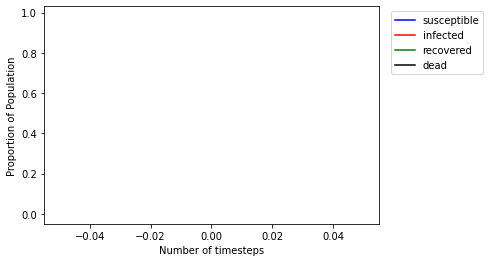

In [ ]:
initialize()
update()
observe()

In [ ]:
# Run the model live inline for a specified number of steps
numruns = 30
timesteps = 120 #denotes 60 days 
sdataarray = np.zeros([timesteps,numruns])
idataarray = np.zeros([timesteps,numruns])
rdataarray = np.zeros([timesteps,numruns])
ddataarray = np.zeros([timesteps,numruns])
for s in range(0,numruns):
  initialize()
  for i in range(0,timesteps):
    #observe()
    update()
  sdataarray[:,s] = np.array(sdata)/totalpopulation
  idataarray[:,s] = np.array(idata)/totalpopulation
  rdataarray[:,s] = np.array(rdata)/totalpopulation
  ddataarray[:,s] = np.array(ddata)/totalpopulation
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    #time.sleep(0.5)
    #if i%10==0: plt.show() #show the plot every 10 steps


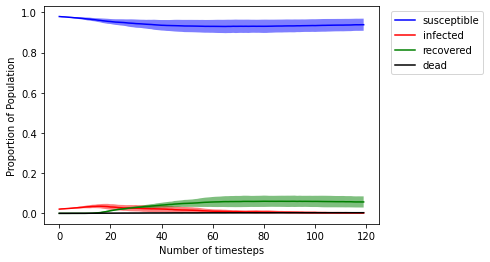

In [ ]:
## Visualizing the mean and variance of different simulations 
fig, ax = plt.subplots(1)
ax.fill_between(range(timesteps),np.mean(sdataarray,axis=1)+np.std(sdataarray,axis=1),np.mean(sdataarray,axis=1)-np.std(sdataarray,axis=1),facecolor = 'b',alpha = 0.5)
ax.fill_between(range(timesteps),np.mean(idataarray,axis=1)+np.std(idataarray,axis=1),np.mean(idataarray,axis=1)-np.std(idataarray,axis=1),facecolor = 'r',alpha = 0.5)
ax.fill_between(range(timesteps),np.mean(rdataarray,axis=1)+np.std(rdataarray,axis=1),np.mean(rdataarray,axis=1)-np.std(rdataarray,axis=1),facecolor = 'g',alpha = 0.5)
ax.fill_between(range(timesteps),np.mean(ddataarray,axis=1)+np.std(ddataarray,axis=1),np.mean(ddataarray,axis=1)-np.std(ddataarray,axis=1),facecolor = 'k',alpha = 0.5)
ax.plot(range(timesteps),np.mean(sdataarray,axis=1),'b',label = 'susceptible')
ax.plot(range(timesteps),np.mean(idataarray,axis=1),'r',label = 'infected')
ax.plot(range(timesteps),np.mean(rdataarray,axis=1),'g',label = 'recovered')
ax.plot(range(timesteps),np.mean(ddataarray,axis=1),'k',label = 'dead')
plt.xlabel('Number of timesteps')
plt.ylabel('Proportion of Population')
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

In [ ]:
#Storing statistics for different scenarios - only run once for each initialization
maxinfected = []
totaldeaths = []
peaktime = []


In [ ]:
#Store these model outcomes 
maxinfected.append(np.max(np.mean(idataarray,axis=1))) #Maximum infection proportion
totaldeaths.append(np.mean(ddataarray,axis=1)[timesteps-1]) #Total death proportion
peaktime.append(np.argmax(np.mean(idataarray,axis=1))) #Time it takes to reach the maximum infection peak
print(maxinfected)
print(totaldeaths)
print(peaktime)

[0.6382666666666668, 0.0362, 0.14, 0.2464, 0.035466666666666674]
[0.038733333333333335, 0.0015333333333333334, 0.021400000000000006, 0.014400000000000001, 0.0032000000000000006]
[25, 8, 13, 20, 16]


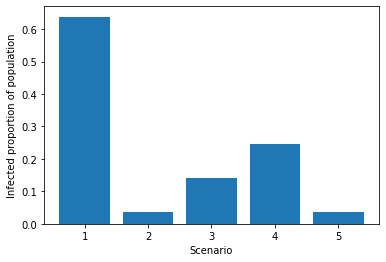

In [ ]:
#Plot the comparison for maximum infected
scenario = [1, 2, 3, 4, 5]
x_pos = [i for i, _ in enumerate(scenario)]

plt.bar(x_pos, maxinfected)
plt.xlabel("Scenario")
plt.ylabel("Infected proportion of population")
plt.xticks(x_pos, scenario)
plt.show()

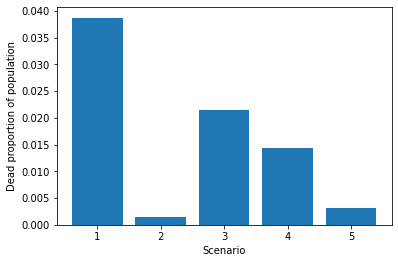

In [ ]:
#Plot the comparison for total death toll 
plt.bar(x_pos, totaldeaths)
plt.xlabel("Scenario")
plt.ylabel("Dead proportion of population")
plt.xticks(x_pos, scenario)
plt.show()

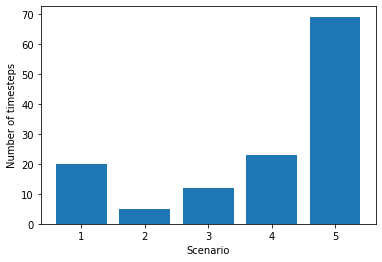

In [ ]:
#Plot comparison for peak time 
plt.bar(x_pos, peaktime)
plt.xlabel("Scenario")
plt.ylabel("Number of timesteps")
plt.xticks(x_pos, scenario)
plt.show()